In [1]:
#Week 11

#Z-score the firing rates.

# Week 11

### Z-score the firing rates? Investigate firing rates, why are they negative.


- Create dataframe
- Doublecheck the bumpdirection accuracy of session 2 and 3.
- Predict velocity based on Projections
------
- Investigate difference between passive and active trials based on PCA projections
    - Check the decoding efficiency difference between running PCA on active/passive only vs. PCA over everything and then splitting the trials.
        -  Probably the first option.
    - What differences? THINK ABOUT THIS.
        - The time shift results in different decoding efficiency
        - Shape of projection could be different
- Train model on active only, test on passive (and vice versa).
- Investigate whether dynamics are different between act/pas
- Investigate possible time-shift between kinematics and S1/reduced dimension.
- Investigate dynamics of PCA
- Investigate the efficiency of decoding for specific PC's. Right now, decoding on all PC's only.

Sidequests:
- Investigate session 0.


In [2]:
import numpy as np
from utility import get_session_trials
from predicting import predict_position
from data_processing import create_df
from data_processing import get_data
import pandas as pd
from tqdm.notebook import tqdm
from df_processing import create_df, update_df_bin_size

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from final_functions import create_dataset
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from pca_functions import session_PCA


from sklearn.model_selection import cross_val_score, KFold

#For firing rate calculation
import scipy.signal as scs
import scipy.ndimage

# Investigating negative firing rates

Turns out I was removing cross condition mean since they did that in the jupyter notebook as well. Investigating whether there's a difference or not:

In [3]:
tD = create_dataset(bin_size=0.05, print_info=False, remove_electrodes=True, subtract=True)
tD2 = create_dataset(bin_size=0.05, print_info=False, remove_electrodes=True, subtract=False)

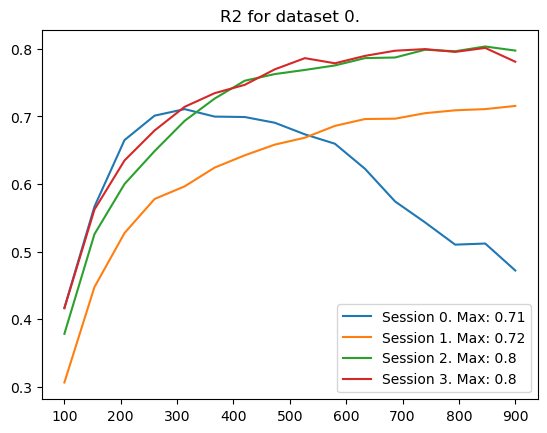

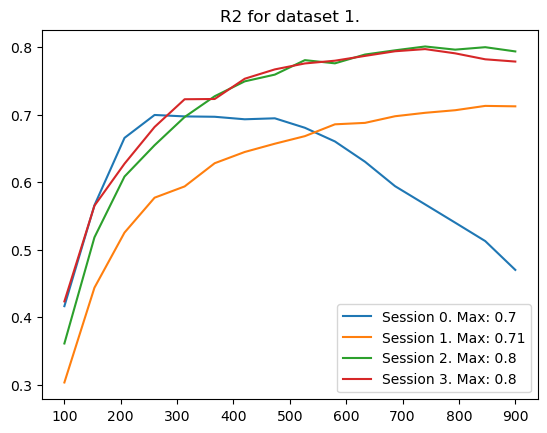

In [4]:
posts = np.linspace(100, 900, 16)

for j, dataset in enumerate([tD, tD2]):
    for i in [0, 1, 2, 3]:
        scores = []
        for post in posts:
            PCA_model, PCA_components = session_PCA(dataset[i], 10, 0, post/10)
            trials = get_session_trials(dataset[i])
            scores.append(predict_position(trials, Ridge(), 0, post, folds=10))
        plt.plot(posts, scores, label=f'Session {i}. Max: {np.round(max(scores), 2)}')
    plt.legend()
    plt.title(f'R2 for dataset {j}.')
    plt.show()


# Creating the dataframe

To do:
- Get Acceleration
- Get movement onset bin
- Get firing rates
- Enable bin size editing

In [5]:
base_df = create_df(get_data())
df = base_df.drop(['force', 'markers', 'joint_ang', 'joint_vel', 'muscle_len', 'muscle_vel'], axis=1)

# Updating the bin size

Index(['trialID', 'monkey', 'task', 'date_time', 'original_bin_size', 'result',
       'bumpDir', 'tgtDir', 'ctrHoldBump', 'ctrHold', 'idx_startTime',
       'idx_endTime', 'idx_bumpTime', 'idx_goCueTime', 'idx_tgtOnTime', 'pos',
       'vel', 'S1_spikes', 'session', 'bin_size', 'old_idx_startTime',
       'old_idx_endTime', 'old_idx_bumpTime', 'old_idx_goCueTime',
       'old_idx_tgtOnTime', 'old_pos', 'old_vel', 'old_S1_spikes'],
      dtype='object')
   idx_startTime  old_idx_startTime
0             60                303
1            128                640
2            191                957
3            257               1289
4            317               1585


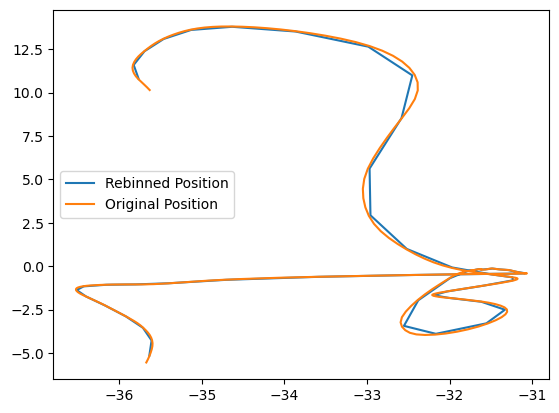

Old sum: [array([ 45,  28,  67,  11,  22,  75,  19,  42,  63,   4,   8,  24,  76,
         3,   9,  29,  13,   3,   3,  29,  20,  84,  21,  27,  48,  11,
        24,  47,   5,  14,   6,   0,   7,  11,   9,   4,   5,  12,   4,
         9,   4,   3,   0, 122,   6,  21,  26,   9,   3,   2,  35,  12,
         5,   7,  19,  12,  30,   4,  46,  40,  36,  28,  38,  20,  49,
        23,  36,   8,   0,  32,  24,  27,  27,  13,  17,  96, 128,  20,
        20,   7,   8,   6], dtype=uint32)].
Sum new: [array([ 45,  28,  67,  11,  22,  73,  19,  42,  63,   4,   7,  24,  76,
         3,   9,  29,  13,   3,   3,  29,  20,  84,  21,  27,  48,  11,
        24,  46,   5,  14,   5,   0,   7,  11,   9,   4,   5,  12,   3,
         9,   4,   3,   0, 122,   6,  21,  26,   9,   3,   2,  35,  10,
         5,   7,  19,  11,  30,   4,  46,  40,  35,  28,  38,  20,  48,
        22,  36,   8,   0,  32,  23,  27,  27,  13,  17,  96, 127,  20,
        20,   7,   8,   6], dtype=uint32)]


In [6]:
def update_df_bin_size(df, bin_size, remove=True):
    trial_df = df.copy()
    bin_step = int(bin_size / 0.01) #original bin size
    idx_fields = [col for col in trial_df.columns if col.startswith("idx")]
    

    #Updating the markers
    for field in idx_fields:
        #Taking int (// instead of /)
        trial_df[f'old_{field}'] = trial_df[field]
        trial_df[field] = [value // bin_step for value in trial_df[field]]
        #While we're here, update to int64 to accomodate for some nans
        trial_df[field]= trial_df[field].astype('Int64')
    
    time_varying_fields = ['pos', 'vel']

    def rebin(array, function, step_size):
        # Get shape of array
        if len(array.shape) == 1:
            T = len(array)
            array = array[:int((T // step_size) * step_size)]
            array = array.reshape(-1, step_size)
        else:
            T, N = array.shape
            # Remove leftovers
            T = int((T // step_size) * step_size)
            array = array[:T, :]
            # Reshape with bin size
            array = array.reshape(int(T / step_size), step_size, N)
        # Then squeeze after performing the function
        return function(array, axis=1).squeeze()

    for field in time_varying_fields:
        trial_df[f'old_{field}'] = trial_df[field]
        trial_df[field] = [rebin(array, np.mean, bin_step) for array in trial_df[field]]
    
    if 'acc' in trial_df.columns:
        trial_df['acc_before_rebin'] = trial_df['acc']
        trial_df['acc'] = [rebin(array, np.sum, bin_step) for array in trial_df['acc']]


    #Update spikes same way, but summing instead of mean
    trial_df['old_S1_spikes'] = trial_df['S1_spikes']
    trial_df['S1_spikes'] = [rebin(array, np.sum, bin_step) for array in trial_df['S1_spikes']]

    if remove:
        keep = [col for col in df.columns if not col.startswith('old')]
        for col in trial_df.columns:
            if col not in keep:
                trial_df = trial_df.drop(col, axis=1)
    trial_df['bin_size'] = bin_size
    return trial_df

binned_df = update_df_bin_size(df, 0.05,remove=False)
print(binned_df.columns)
print(binned_df[['idx_startTime', 'old_idx_startTime']].head(5))
t1 = binned_df.iloc[4]
plt.plot(t1['pos'][:, 0], t1['pos'][:, 1], label='Rebinned Position')
plt.plot(t1['old_pos'][:, 0],t1['old_pos'][:, 1], label='Original Position')
plt.legend()
plt.show()
sum_old = [np.sum(t1['old_S1_spikes'],axis=0)]
sum_new = [np.sum(t1['S1_spikes'],axis=0)]
print(f'Old sum: {sum_old}.')
print(f'Sum new: {sum_new}')

        
    

    



# Firing rate calculation

In [7]:
def compute_firing_rates(spikes, bin_size, std):
    """
    Function which smoothes given spiking rates into firing rates using a gaussian window.
        
    Args:
    ----------
        - spikes (array):
            Spiking rates of one electrode over the duration of a trial
            Basic value of 50 MS.
        - bin_size (float):
            The bin size in ms.
        - std (float):
            Standard deviation of the gaussian. Calculated automatically if halfwidth
            of the gaussian is given.
    
    Returns:
    ----------
        Smooth firing rates of one electrode over the duration of the trial
    """
    gaussian_window = scs.windows.gaussian((10*std)/bin_size, std / bin_size)
    norm_gaussian = gaussian_window / np.sum(gaussian_window)
    return scipy.ndimage.convolve1d(np.sqrt(spikes).astype(np.float32), norm_gaussian,axis=0,output=np.float32, mode='reflect') / bin_size

def add_firing_rates(data_df, std=0.05):
    df=data_df.copy()
    df['firing_rates'] = df.apply(lambda row: np.array(compute_firing_rates(row['S1_spikes'], row['bin_size'], std).astype(int)), axis=1)
    return df


In [8]:
test = df.copy()
test2 = binned_df.copy()
test['firing_rates'] = test.apply(lambda row: compute_firing_rates(row['S1_spikes'], row['original_bin_size'], 0.05).astype(int), axis=1)
test2['firing_rates'] = test2.apply(lambda row: compute_firing_rates(row['S1_spikes'], row['original_bin_size'],0.05).astype(int), axis=1)

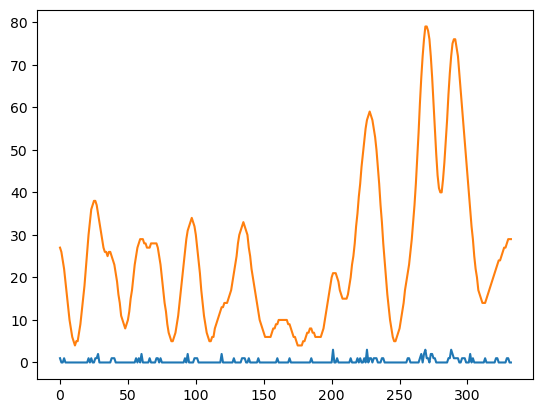

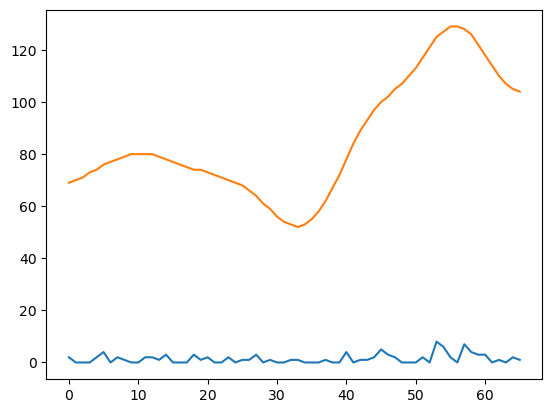

Sum of unbinned: 26. Sum of binned: 26.


In [9]:
t1 = test.iloc[5]
t2 = test2.iloc[5]
#plt.plot(t1.firing_rates[:,4])
plt.plot(t1.S1_spikes[:, 5])
plt.plot(t1.firing_rates[:, 5])
plt.show()
plt.plot(t2.S1_spikes[:, 5])
plt.plot(t2.firing_rates[:, 5])
plt.show()
print(f'Sum of unbinned: {sum(t1.S1_spikes[:, 4])}. Sum of binned: {sum(t1.S1_spikes[:, 4])}.')


# Removal of low-firing neurons

In [10]:
def remove_low_firing_neurons(base_df, threshold, bin_size):
    df = base_df.copy()
    grouped_spikes = df.groupby('session')['S1_spikes'].agg(np.array)
    
    for i, session_spikes in enumerate(grouped_spikes):
        grouped_session_spikes = np.concatenate(session_spikes, axis=0)
        averages_per_electrode = np.mean(grouped_session_spikes, axis=0) / bin_size
        bad_electrodes = np.where(averages_per_electrode < threshold)[0]
        df.loc[df['session'] == i, 'S1_spikes'] = df.loc[df['session'] == i, 'S1_spikes'].apply(lambda x: np.array([x[:, electrode] for electrode in range(x.shape[1]) if electrode not in bad_electrodes]).T)
    return df

test = df.copy()
test2 = remove_low_firing_neurons(test, 5, 0.01)

In [11]:
print(test.S1_spikes.loc[1].shape)
print(test2.S1_spikes.loc[1].shape)

(317, 82)
(317, 39)


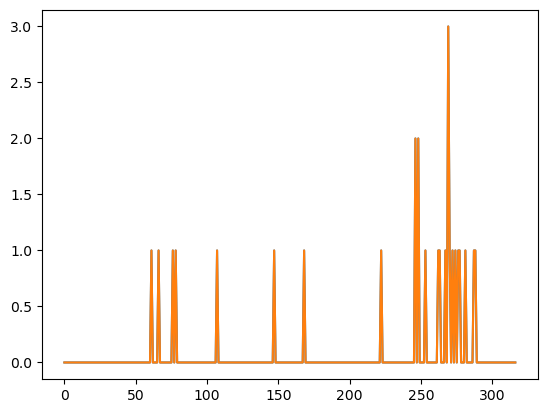

In [12]:
t1 = test.S1_spikes.loc[1]
t2 = test2.S1_spikes.loc[1]
plt.plot(t1[:, 4])
plt.plot(t2[:, 3])

# Mean centering position

In [13]:
def mean_center_position(session):
    positions = session['pos']
    #Calculate mean while we're ignoring nans
    mean_x = np.nanmean(positions[:, 1])
    mean_y = np.nanmean(positions[:, 0])
    positions[:, 1] -= mean_x
    positions[:, 0] -= mean_y
    session['pos'] = positions
    return positions

def center_position(data):
    df = data.copy()
    df['old_pos'] = df.pos
    grouped_df = df.groupby('session')
    for session, session_df in grouped_df:
        all_positions = np.concatenate(session_df['pos'].values, axis=0)
        avg_x = np.nanmean(all_positions[:, 0])
        avg_y = np.nanmean(all_positions[:, 1])
        data.loc[data['session'] == session, 'pos'] = session_df['pos'].apply(
            lambda trial: np.array([pos - [avg_x, avg_y] for pos in trial])
        )
    return data





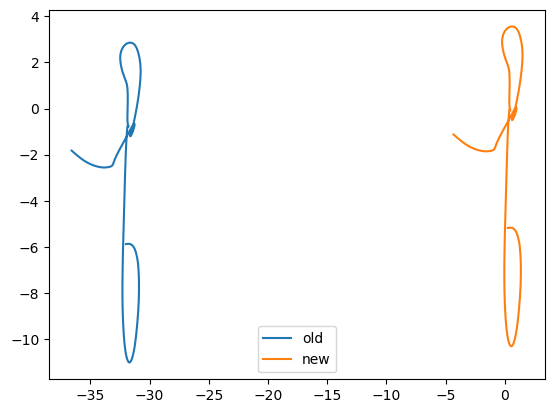

In [14]:
test = df.copy()
t1 = test.loc[1358]
plt.plot(t1.pos[:, 0], t1.pos[:,1], label='old')
test2 = center_position(test)
t2=test2.loc[1358]
plt.plot(t2.pos[:, 0], t2.pos[:,1], label='new')
plt.legend()
plt.show()

# Position check

Position swap added to beginning of DF creation.

Result: R. Bumpdir: 270.0


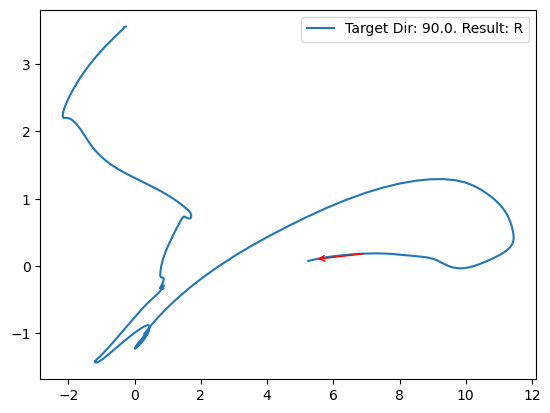

Result: R. Bumpdir: <NA>


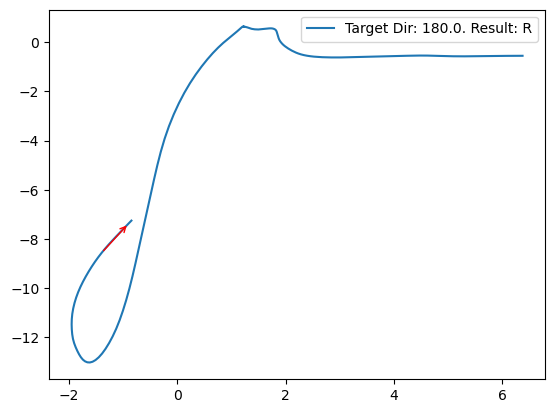

Result: A. Bumpdir: 315.0


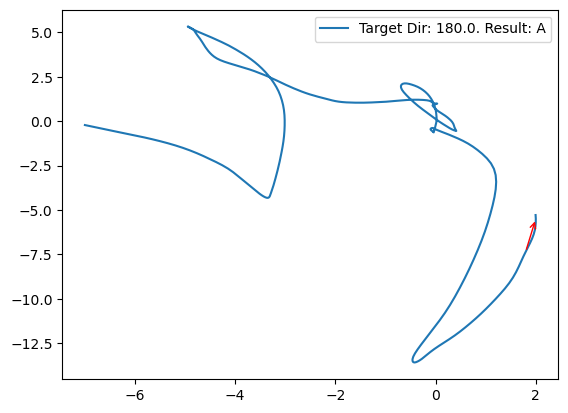

Result: I. Bumpdir: <NA>


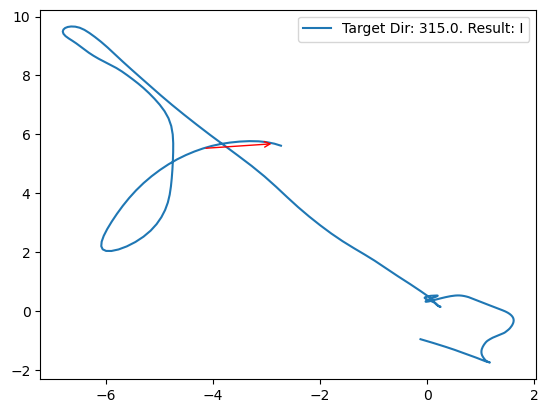

In [15]:
t1, t2, t3, t4 = test.loc[10], test.loc[1000], test.loc[2034], test.loc[3000]
for trial in [t1,t2,t3,t4]:
    x = trial.pos[:, 0]
    y = trial.pos[:, 1]
    print(f'Result: {trial.result}. Bumpdir: {trial.bumpDir}')
    plt.plot(x, y, label=f'Target Dir: {trial.tgtDir}. Result: {trial.result}')
    
    # Add an arrow at the end of the line
    arrow_properties = dict(facecolor='red', edgecolor='red', arrowstyle='->')
    plt.annotate('', xy=(x[-2], y[-2]), xytext=(x[-10], y[-10]), arrowprops=arrow_properties)

    plt.legend()
    plt.show()

# Determining movement onset

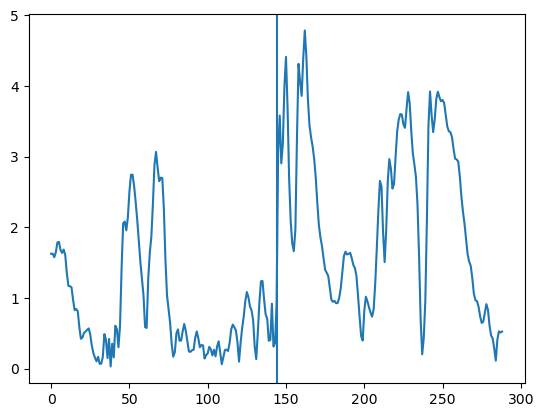

In [16]:
def calculate_accelerations(x, y):
    """
    Function used to calculate the accelerations based on the velocities.
    """
    deltas_x = np.diff(x)
    deltas_y = np.diff(y)

    # To combine the 2D velocity deltas, take the Euclidean norm.
    accelerations = np.sqrt(deltas_x**2 + deltas_y**2)

    return accelerations

def add_acc(data_df):
    df = data_df.copy()
    df['acc'] = df['vel'].apply(lambda vel_array: calculate_accelerations(vel_array[:, 0], vel_array[:,1]))
    return df

def find_mvmt_onset(row_acc, center_index, threshold, span):
    #Start at center to avoid taking previous trial's acc.
    max_index = np.argmax(row_acc[int(center_index):int(center_index + span)]) + center_index
    max_value = row_acc[max_index]
    mvmt_onset_marker = max_index
    for i in range(max_index, center_index-4, -1):
        if row_acc[i] > 0.1*max_value:
            mvmt_onset_marker = i
        else:
            for j in range(threshold, 0, -1):
                if row_acc[i-j] > 0.7 * max_value:
                    i=j
                    break
    return mvmt_onset_marker
    


def set_movement_onset(data_df, threshold):
    df = data_df.copy()
    threshold //= int((100*df.bin_size.loc[0]))
    df['idx_movementOnset'] = df.apply(lambda row: pd.NA if pd.isna(row['idx_goCueTime']) else find_mvmt_onset(row['acc'], int((row['idx_goCueTime']-row['idx_startTime'] if pd.isna(row['idx_bumpTime']) else row['idx_bumpTime']-row['idx_startTime'])), threshold, 100) + row['idx_startTime'], axis=1)
    return df
    


test = create_df(get_data())
test = add_acc(test)
#test = test[test['result']== 'R'].copy()
# t1 = test.loc[2471]
# if not np.isnan(t1.idx_bumpTime):
#     bumpframe = int(t1.idx_bumpTime - t1.idx_startTime)
# cueframe = int(t1.idx_goCueTime -t1.idx_startTime)
# print(cueframe)

# asdf = find_mvmt_onset(t1.acc,(cueframe if np.isnan(t1.bumpDir) else bumpframe), 2,100)

# plt.plot(t1.acc)
# plt.axvline(t1.idx_bumpTime - t1.idx_startTime, color='red')
# plt.axvline(t1.idx_goCueTime - t1.idx_startTime, color='y')
# plt.axvline(asdf, color='green')
# plt.title(f'{t1.result}, bumpdir={t1.bumpDir}')


test = set_movement_onset(test, 100)
t1 = test.loc[6]
plt.plot(t1.acc)
plt.axvline(t1.idx_movementOnset-t1.idx_startTime)

In [17]:
tD_object = create_dataset(bin_size=0.01, print_info=False, remove_electrodes=True, subtract=False)
tD_df = create_df(get_data())
tD_df = add_acc(tD_df)
print(tD_df.columns)
#tD_df = tD_df[tD_df['result'] == 'R'].copy().reset_index(drop=True)
tD_df = set_movement_onset(tD_df, 100)

Index(['trialID', 'monkey', 'task', 'date_time', 'original_bin_size', 'result',
       'bumpDir', 'tgtDir', 'ctrHoldBump', 'ctrHold', 'idx_startTime',
       'idx_endTime', 'idx_bumpTime', 'idx_goCueTime', 'idx_tgtOnTime', 'pos',
       'vel', 'force', 'markers', 'joint_ang', 'joint_vel', 'muscle_len',
       'muscle_vel', 'S1_spikes', 'session', 'bin_size', 'acc'],
      dtype='object')


In [18]:
t1=tD_df.loc[1802]
t2=tD_object[1]['90.0']['270.0'][33]
print(t2)

This is data for trial 1165, performed on monkey C from a session recorded on 2017/9/13 19:0:22.178.


In [19]:
t1

trialID                                                           1165
monkey                                                               C
task                                                          COactpas
date_time                                        2017/9/13 19:0:22.178
original_bin_size                                                 0.01
result                                                               R
bumpDir                                                           90.0
tgtDir                                                           270.0
ctrHoldBump                                                          1
ctrHold                                                       0.950524
idx_startTime                                                   325989
idx_endTime                                                     326220
idx_bumpTime                                                  326125.0
idx_goCueTime                                                 326167.0
idx_tg

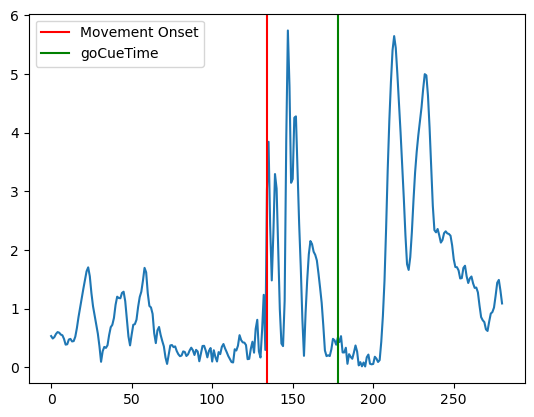

In [20]:
plt.plot(t1.acc)
plt.axvline((t1.idx_movementOnset) - t1.idx_startTime,color='red',label='Movement Onset')
plt.axvline((t1.idx_goCueTime) - t1.idx_startTime, color='green', label='goCueTime')
plt.legend()
plt.show()

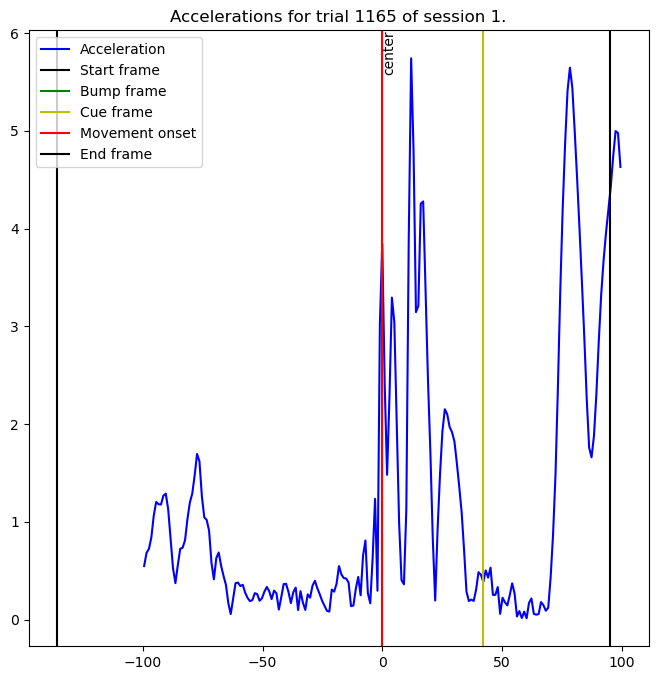

In [21]:
t2.plot_acceleration()

In [22]:
import ipywidgets as widgets


xcoords = t1.pos[:, 0]
ycoords = t1.pos[:, 1]

cuetime = int(t1.idx_goCueTime - t1.idx_startTime)
if not np.isnan(t1.bumpDir):
    bump = int(t1.idx_bumpTime - t1.idx_startTime)
else: bump=0

def update_plot(time_point):
    plt.figure(figsize=(5, 5))
    plt.scatter(xcoords, ycoords, label='Arm Position')
    # plt.scatter(xcoords[movement], ycoords[movement], color='green', label='Movement Onset')
    plt.scatter(xcoords[cuetime], ycoords[cuetime], color='yellow', label=f'Cue to {t1.tgtDir} at {cuetime}')
    plt.scatter(xcoords[time_point], ycoords[time_point], color='red', label='Selected Time Point')
    if not np.isnan(t1.bumpDir):
        plt.scatter(xcoords[bump], ycoords[bump], color='magenta', label=f'Bump to {t1.bumpDir} at {t1.idx_bumpTime-t1.idx_startTime}')
    plt.title(f'Arm Position at Time Point {time_point}')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.show()

# Create a slider widget for selecting the time point
time_slider = widgets.IntSlider(min=0, max=len(xcoords) - 1, step=1, value=0, description='Time Point')

# Create an interactive UI
interactive_plot = widgets.interactive(update_plot, time_point=time_slider)
output = interactive_plot.children[-1]
output.layout.height = '500px'
interactive_plot

interactive(children=(IntSlider(value=0, description='Time Point', max=281), Output(layout=Layout(height='500p…

# Square root transforming spikes

In [23]:
def square_root_stabilizing(data_df):
    df = data_df.copy()
    df['S1_spikes_old'] = df['S1_spikes']
    df['S1_spikes'] = df['S1_spikes'].apply(lambda row: np.sqrt(row))
    return df

test = create_df(get_data())
print(test.loc[1].S1_spikes.shape)
test = square_root_stabilizing(test)
print(test.loc[1].S1_spikes.shape)

(317, 82)
(317, 82)


# Removing Nans from time-varying stuff
Not harmful to remove. Only removing arrays which fully consist of nans

In [24]:
def remove_nan_arrays(arrays):
    # Create a boolean mask for each inner array, indicating NaN values
    nan_mask = np.isnan(arrays).any(axis=(1))
    
    # Filter the arrays based on the negation of the NaN mask
    cleaned_arrays = [arr for arr, nan_row in zip(arrays, nan_mask) if not nan_row]
    
    return np.array(cleaned_arrays)

def clean_nans(data_df):
    df = data_df.copy()
    df['pos'] = df.pos.apply(lambda x: remove_nan_arrays(x))
    df['vel'] = df.vel.apply(lambda x: remove_nan_arrays(x))
    return df


print(test.loc[0].pos[40:60])
print(type(test.loc[0].pos))
print(test.loc[0].pos.shape)
test['pos'] = test.pos.apply(lambda x: remove_nan_arrays(x))
print(test.loc[0].pos)

[[         nan          nan]
 [-34.37103928   2.19874913]
 [-34.238469     2.08480664]
 [-34.11179216   1.97430166]
 [-33.98863309   1.86962215]
 [-33.86727721   1.77165123]
 [-33.74929016   1.67943197]
 [-33.63711756   1.59195981]
 [-33.53154911   1.50954109]
 [-33.43217428   1.43327737]
 [-33.33888742   1.36355301]
 [-33.25284132   1.29941979]
 [-33.17629778   1.23983289]
 [-33.11093501   1.18519412]
 [-33.05658729   1.13686752]
 [-33.01252855   1.09532557]
 [-32.97897406   1.05970742]
 [-32.95603174   1.02915213]
 [-32.94227062   1.00373465]
 [-32.93557761   0.98409685]]
<class 'numpy.ndarray'>
(640, 2)
[[-34.37103928   2.19874913]
 [-34.238469     2.08480664]
 [-34.11179216   1.97430166]
 ...
 [-34.54941676   8.88018591]
 [-34.5804767    8.68870258]
 [-34.61313697   8.49657659]]


# Filtering trials that take too long

In [25]:
def remove_long_trials(data_df, threshold):
    df = data_df.copy()
    df['trial_duration'] = df['idx_endTime'] - df['idx_startTime']
    df.loc[df['trial_duration'] > threshold, 'result']= 'A'
    return df
 

# Putting it all together

(317, 82)


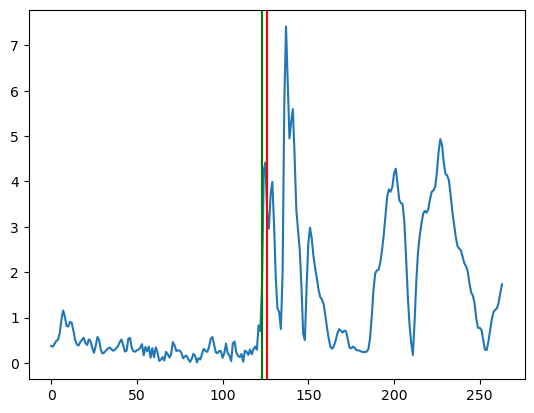

S1 Spikes before rebinning: (317, 39)
S1 Spikes after rebinning: (63, 39)
Firing Rates after: (63, 39)


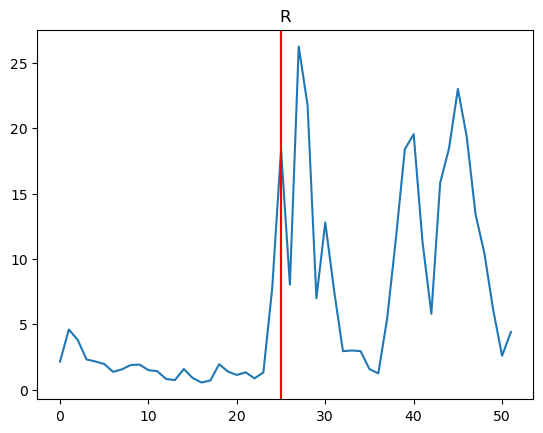

In [26]:
bin_size = 0.05
removal_threshold = 5
main_df = create_df(get_data())
main_df = remove_long_trials(df, 1000)
main_df = clean_nans(main_df)
main_df = square_root_stabilizing(main_df)
main_df = center_position(main_df)
main_df = add_acc(main_df)
main_df = set_movement_onset(main_df, 250)
print(main_df.loc[1].S1_spikes.shape)
main_df = remove_low_firing_neurons(main_df, removal_threshold, 0.01)


plt.plot(main_df.loc[100].acc)
plt.axvline(main_df.loc[100].idx_movementOnset - main_df.loc[100].idx_startTime, color='green')
plt.axvline(main_df.loc[100].idx_bumpTime - main_df.loc[100].idx_startTime, color='red')
plt.show()

#Bin size update:
print(f'S1 Spikes before rebinning: {main_df.loc[1].S1_spikes.shape}')
main_df = update_df_bin_size(main_df, bin_size, False)
print(f'S1 Spikes after rebinning: {main_df.loc[1].S1_spikes.shape}')
main_df = add_firing_rates(main_df)
print(f'Firing Rates after: {main_df.loc[1].firing_rates.shape}')



plt.plot(main_df.loc[100].acc)
plt.axvline(main_df.loc[100].idx_movementOnset - main_df.loc[100].idx_startTime, color='green')
plt.axvline(main_df.loc[100].idx_bumpTime - main_df.loc[100].idx_startTime, color='red')
plt.title(main_df.loc[100].result)
plt.show()

# Above is to show that bin resizing works efficiently.

# Below is to show that firing rate is applied correctly.

#### Note that a shift is made due to the new implementation containing all datapoints, not within some set margin.

Creating dataset with the following parameters:
            Bin size = 0.01 seconds
            Stdev = 0.05 seconds
            Gaussian halfwidth = None seconds
            Acceleration threshold = 10.0 bins
            Firing Rate calculated for 500.0 bins prior- and post-movement onset.
Data loaded from pickle file
Trials extracted.
Good trials filtered.
Dictionary with data constructed.


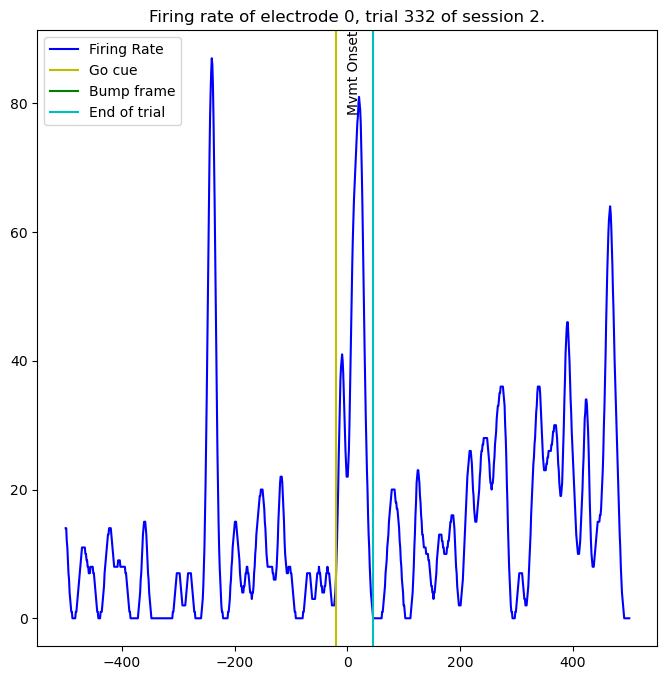

In [27]:
tD = create_dataset(bin_size=0.01,firing_rate_halfwidth=500)
tD_trials = get_session_trials(tD[2])
t3 = tD_trials[200]
t3.plot_firing_rates(electrode=0)

trialID                                                           1165
monkey                                                               C
task                                                          COactpas
date_time                                        2017/9/13 19:0:22.178
original_bin_size                                                 0.01
result                                                               R
bumpDir                                                           90.0
tgtDir                                                           270.0
ctrHoldBump                                                          1
ctrHold                                                       0.950524
idx_startTime                                                   325989
idx_endTime                                                     326220
idx_bumpTime                                                  326125.0
idx_goCueTime                                                 326167.0
idx_tg

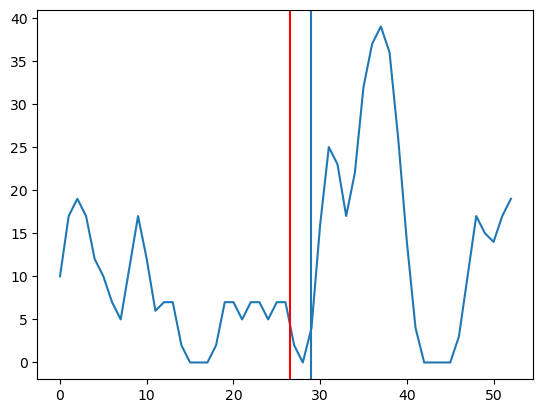

In [28]:
print(t1)
t2 = main_df.loc[(main_df['session']==2) & (main_df['trialID'] == 332)]
#print(t2['firing_rates'].iloc[0][:5])
plt.plot(t2.firing_rates.iloc[0][:, 0])
plt.axvline(t2.firing_rates.iloc[0][:, 2].shape[0] / 2, color='red')
plt.axvline(t2.idx_movementOnset.iloc[0] - t2.idx_startTime.iloc[0])
plt.show()

In [29]:
def predict_position(trials, model, prior, post, folds=10, scorer: str = 'r2'):
    if prior != 0:
        prior = int(prior / (1000 * trials[0]._bin_size))
    if post != 0:
        post = int(post / (1000 * trials[0]._bin_size))
    X, y = [], []
    for trial in trials:
        X.append(trial.projections.flatten())
        y.append(np.concatenate(trial.pos[trial.margin-prior: trial.margin+post, ], axis=0))
    cv_scores = cross_val_score(model, X, y , cv=KFold(folds, shuffle=True), scoring=scorer)
    return cv_scores.mean()



In [30]:
def df_pos_from_fr(session_df, prior, post, model, folds=10, scorer:str = 'r2'):
    bin_size = session_df['bin_size'].iloc[0]
    if prior!= 0:
        prior = int(prior / (1000 * bin_size))
    if post != 0:
        post = int(post / (1000 * bin_size))
    X = [x.firing_rates[(x["idx_movementOnset"] - x["idx_startTime"]-prior):(x["idx_movementOnset"] - x["idx_startTime"]+post), :].flatten() for _,x in session_df.iterrows()]
    y = [np.concatenate(x.pos[(x["idx_movementOnset"] - x["idx_startTime"]-prior):(x["idx_movementOnset"] - x["idx_startTime"]+post), :], axis=0) for _,x in session_df.iterrows()]
    print(len(X), len(y))
    print(X[1].shape, y[1].shape)
    cv_scores = cross_val_score(model, X, y, cv=KFold(folds, shuffle=True), scoring=scorer)
    return cv_scores.mean()



test = main_df[(main_df['session'] == 2) & (main_df['result'] == 'R') ].copy().reset_index(drop=True)
print(test.columns)
df_pos_from_fr(test, 0, 200, Ridge())


Index(['trialID', 'monkey', 'task', 'date_time', 'original_bin_size', 'result',
       'bumpDir', 'tgtDir', 'ctrHoldBump', 'ctrHold', 'idx_startTime',
       'idx_endTime', 'idx_bumpTime', 'idx_goCueTime', 'idx_tgtOnTime', 'pos',
       'vel', 'S1_spikes', 'session', 'bin_size', 'trial_duration',
       'S1_spikes_old', 'acc', 'idx_movementOnset', 'old_idx_startTime',
       'old_idx_endTime', 'old_idx_bumpTime', 'old_idx_goCueTime',
       'old_idx_tgtOnTime', 'old_idx_movementOnset', 'old_pos', 'old_vel',
       'acc_before_rebin', 'old_S1_spikes', 'firing_rates'],
      dtype='object')
482 482
(348,) (8,)


-1.1917890243579852

# Annoyingly, it appears that the endtime is an annoying roadblock: Should make it so that I can just decide how many bins are taken after the 'endtime'.
I could attempt to take the information up to the start of the next trial, instead of the end of the current one.

In [31]:
prior=0
post=200
for _, x in test.iterrows():
    print(x.pos.shape)
    #print(x.pos[(x.idx_movementOnset - x.idx_startTime):].shape)
    #print(np.concatenate(x.pos[(x.idx_movementOnset - x.idx_startTime-prior):(x.idx_movementOnset - x.idx_startTime+post),:],axis=0))
    print(np.concatenate(x.pos[(x.idx_movementOnset - x.idx_startTime-prior):(x.idx_movementOnset - x.idx_startTime+post),:],axis=0).shape, x.result)

(118, 2)
(190,) R
(58, 2)
(48,) R
(63, 2)
(58,) R
(71, 2)
(98,) R
(49, 2)
(42,) R
(48, 2)
(40,) R
(46, 2)
(32,) R
(55, 2)
(54,) R
(56, 2)
(74,) R
(64, 2)
(68,) R
(76, 2)
(44,) R
(76, 2)
(84,) R
(81, 2)
(96,) R
(48, 2)
(38,) R
(57, 2)
(44,) R
(54, 2)
(32,) R
(77, 2)
(106,) R
(77, 2)
(32,) R
(69, 2)
(44,) R
(52, 2)
(46,) R
(67, 2)
(42,) R
(74, 2)
(94,) R
(76, 2)
(96,) R
(67, 2)
(48,) R
(71, 2)
(84,) R
(61, 2)
(34,) R
(61, 2)
(36,) R
(93, 2)
(46,) R
(66, 2)
(50,) R
(57, 2)
(70,) R
(77, 2)
(40,) R
(64, 2)
(68,) R
(44, 2)
(36,) R
(57, 2)
(58,) R
(76, 2)
(74,) R
(83, 2)
(102,) R
(72, 2)
(40,) R
(66, 2)
(74,) R
(50, 2)
(64,) R
(65, 2)
(32,) R
(76, 2)
(38,) R
(58, 2)
(58,) R
(59, 2)
(48,) R
(61, 2)
(70,) R
(44, 2)
(46,) R
(40, 2)
(44,) R
(58, 2)
(70,) R
(76, 2)
(42,) R
(72, 2)
(72,) R
(82, 2)
(84,) R
(61, 2)
(80,) R
(75, 2)
(50,) R
(55, 2)
(42,) R
(63, 2)
(64,) R
(63, 2)
(76,) R
(80, 2)
(84,) R
(54, 2)
(42,) R
(85, 2)
(46,) R
(50, 2)
(40,) R
(65, 2)
(90,) R
(60, 2)
(34,) R
(41, 2)
(40,) R
(43,

# Fix for this issue

Append all spikes together. Then, take the window for the relevant spikes, calculate the firing rates over that whole array and create df.firing_rates_window per trial per session.

### Important Note
The 'firing_rates' column is created by taking all S1_spikes from the end of the previous trial to the end of the current trial. We do this to maintain all data within the dataframe. This creates the ~50ms offset from the length of S1_spikes to the duration of the trial (endTime-startTime).

In [32]:
def df_relevant_firing_rates(data_df, prior, post, bin_size):
    df = data_df.copy()
    session_data = []
    firing_rates = []
    firing_rates_all = []
    for session in [0,1,2,3]:
        spikes = df[df['session'] == session]['S1_spikes'].tolist()
        session_data.append(np.concatenate(spikes))
        firing_rates.append(compute_firing_rates(session_data[session], bin_size, 0.05))
        session_firing_rate = firing_rates[session]
        for i in df[df['session'] == session].index:
            if not pd.isna(df.at[i, 'idx_movementOnset']):
                start = int(df.at[i, 'idx_movementOnset'] - prior)
                stop = int(df.at[i, 'idx_movementOnset'] + post)
                firing_rates_all.append(session_firing_rate[start: stop, ])
                
            else:
                firing_rates_all.append(pd.NA)
    df['firing_rates_window'] = firing_rates_all
    return df, firing_rates


bin_size = 0.01
removal_threshold = 5
maximum_duration_in_ms = 1200
trial = 1500
test_df = create_df(get_data())
print(test_df.iloc[trial].idx_startTime, test_df.iloc[trial].idx_endTime, test_df.iloc[trial].S1_spikes.shape,test_df.iloc[trial].idx_endTime - test_df.iloc[trial].idx_startTime)
test_df = clean_nans(test_df)
test_df = remove_long_trials(test_df,maximum_duration_in_ms)
test_df = square_root_stabilizing(test_df)
test_df = center_position(test_df)
test_df = add_acc(test_df)
test_df = set_movement_onset(test_df, 250)
test_df = remove_low_firing_neurons(test_df, removal_threshold, 0.01)
print(f'S1 Spikes before rebinning: {test_df.loc[trial].S1_spikes.shape}')
test_df = update_df_bin_size(test_df, bin_size, False)
print(f'S1 Spikes after rebinning: {test_df.loc[trial].S1_spikes.shape}')
test_df = add_firing_rates(test_df)
print(f'Firing Rates after: {test_df.loc[trial].firing_rates.shape}')
test_df, all_firing_rates = df_relevant_firing_rates(test_df, 0, 1000, bin_size)
print(f'Windowed Firing Rates after: {test_df.loc[trial].firing_rates_window.shape}')
test_df.head(5)


245071 245332 (311, 57) 261
S1 Spikes before rebinning: (311, 30)
S1 Spikes after rebinning: (311, 30)
Firing Rates after: (311, 30)
Windowed Firing Rates after: (1000, 30)


,trialID,monkey,task,date_time,original_bin_size,result,bumpDir,tgtDir,ctrHoldBump,ctrHold,...,old_idx_bumpTime,old_idx_goCueTime,old_idx_tgtOnTime,old_idx_movementOnset,old_pos,old_vel,acc_before_rebin,old_S1_spikes,firing_rates,firing_rates_window
0,1,C,COactpas,2017/9/12 19:55:38.792,0.01,R,90.0,0.0,1,0.806041,...,506.0,537.0,537.0,503,"[[-1.3072956074396203, 1.9420751692494125], [-...","[[13.54698315442142, -11.496961798433778], [12...","[0.6462234408024589, 0.6896143135770518, 0.698...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 11...","[[18.112156, 0.04692012, 6.2476873, 1.8813024,..."
1,2,C,COactpas,2017/9/12 19:55:38.792,0.01,R,0.0,180.0,1,0.816895,...,805.0,852.0,852.0,802,"[[-1.585946590555956, 8.04746550249921], [-1.6...","[[-3.9480721065389854, -19.273785245306044], [...","[0.7994013853644824, 0.9073457872937926, 0.831...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[26, 16, 12, 0, 0, 0, 10, 5, 0, 1, 0, 0, 3, 3...","[[10.409163, 14.007457, 37.65848, 4.4223824, 3..."
2,3,C,COactpas,2017/9/12 19:55:38.792,0.01,R,0.0,0.0,1,1.087712,...,1121.0,1183.0,1183.0,1118,"[[-0.7758884249593976, -6.375389389303088], [-...","[[1.0118408546553084, 20.41036370035008], [0.6...","[1.0464737590208388, 1.1558018254506548, 1.145...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[15, 0, 42, 20, 13, 0, 19, 16, 0, 0, 0, 19, 1...","[[24.279852, 1.7488577, 3.8167388, 0.06539444,..."
3,4,C,COactpas,2017/9/12 19:55:38.792,0.01,R,90.0,180.0,1,0.842982,...,1449.0,1483.0,1483.0,1447,"[[-1.8016682555326824, 9.162460752630013], [-1...","[[-2.0167358760025165, -22.694931145956918], [...","[0.676382174276658, 0.5398708146299303, 0.5212...","[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[22, 3, 15, 0, 12, 0, 1, 13, 14, 19, 2, 1, 4,...","[[23.625721, 6.3089657, 13.981601, 0.118692935..."
4,5,C,COactpas,2017/9/12 19:55:38.792,0.01,R,180.0,0.0,1,0.952397,...,1740.0,1779.0,1779.0,1737,"[[-2.607786988207799, -5.810416381139827], [-2...","[[2.363659209187163, 20.68680540294281], [1.98...","[0.9024684907439589, 0.9305376541141166, 0.696...","[[0.0, 0.0, 1.414, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[[16, 0, 45, 0, 17, 0, 19, 29, 0, 13, 0, 6, 18...","[[8.866815, 2.1096058, 21.037584, 1.0005084, 1..."


# Graphs below show that the new firing rate data is accurate.

2
231 310


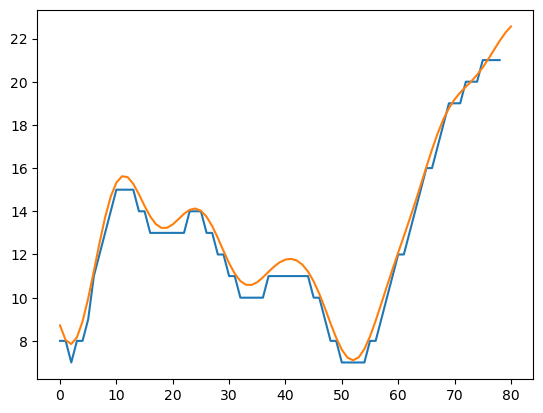

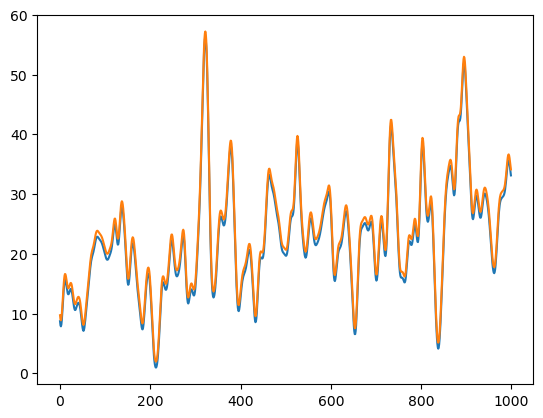

In [33]:
t1 = test_df.iloc[2312]
print(t1.session)
fr = all_firing_rates[t1.session]
should_be_data = fr[t1.idx_movementOnset:t1.idx_movementOnset+1000]
print(t1.idx_movementOnset-t1.idx_startTime, t1.firing_rates.shape[0])
plt.plot(t1.firing_rates[t1.idx_movementOnset-t1.idx_startTime:, 10])
plt.plot(t1.firing_rates_window[:81, 10])
plt.show()

plt.plot(should_be_data[:, 10])
plt.plot(t1.firing_rates_window[:,10]+1)

# Test whether firing rates are similar to previous implementation
### Doesn't look like it. Let's see how the decoding does.

In [34]:
t1 = test_df.iloc[2312]
t2 = tD[2]['NaN']['225.0'][13]

In [35]:
print(f"""
DF: Session, trialID: {t1.session, t1.trialID}
TrialObject: Session, trialID: {t2.session_num, t2.trialID}
bumpdirs: {t1.idx_bumpTime}
Calculated movement onset (df, object): {t1.idx_movementOnset, t2.movement_frame}

""")


DF: Session, trialID: (2, 287)
TrialObject: Session, trialID: (2, 287)
bumpdirs: <NA>
Calculated movement onset (df, object): (80137, 80137.0)




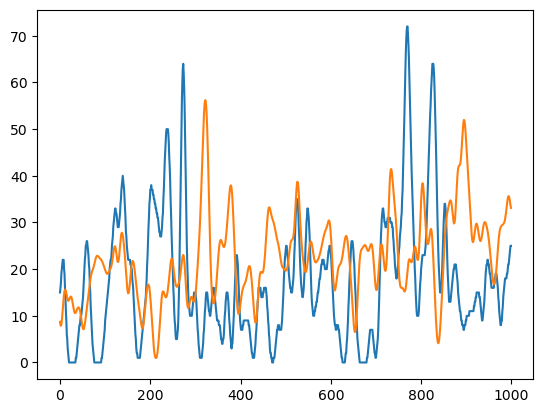

In [36]:
plt.plot(t2.firing_rates[:, 10])
#plt.axvline(t2.movement_frame - t2.start_frame, color='red')
plt.plot(t1.firing_rates_window[:, 10])
plt.show()

In [39]:
def df_relevant_position(data_df, prior, post):
    df = data_df.copy()
    session_positions = []
    all_positions = []
    for session in [0,1,2,3]:
        positions = df[df['session'] == session]['pos'].tolist()
        session_positions.append(np.concatenate(positions))
        session_position = session_positions[session]
        for i in df[df['session'] == session].index:
            if not pd.isna(df.at[i, 'idx_movementOnset']):
                start = int(df.at[i, 'idx_movementOnset'] - prior)
                stop = int(df.at[i, 'idx_movementOnset'] + post)
                all_positions.append(session_position[start: stop, ])
                
            else:
                all_positions.append(pd.NA)
    df['pos_window'] = all_positions
    return df, all_positions



def df_pos_from_fr_window(session_df, prior, post, model, folds=10, scorer:str = 'r2'):
    bin_size = session_df['bin_size'].iloc[0]
    
    if prior!= 0:
        prior = int(prior / (100 * bin_size))
    if post != 0:
        post = int(post / (100 * bin_size))
    
    X = [x.firing_rates_window[:post, :].flatten() for _,x in session_df.iterrows()]
    y = [np.concatenate(x.pos_window[:post, :], axis=0) for _,x in session_df.iterrows()]
    X0 = X[0].shape
    y0 = y[0].shape
    count = 0
    for test in X:
        if test.shape != X0:
            print(f"X ERROR. Shape: {test.shape}. Should be shape: {X0}")
            print(count)
    
    for test in y:
        if test.shape != y0:
            print(f"y ERROR. Shape: {test.shape}. Should be shape: {y0}")
            print(count)
        else:
            count +=1
    cv_scores = cross_val_score(model, X, y, cv=KFold(folds, shuffle=True), scoring=scorer)
    return cv_scores.mean()

test_df,positions = df_relevant_position(test_df, 0, 1000)
data = test_df[(test_df['session'] == 3) & (test_df['result'] == 'R') ].copy().reset_index(drop=True)
final = df_pos_from_fr_window(data, 0, 190, Ridge())
print(final)

0.8800375363297347


# I also have to create a pos_window column!

Done above.

In [40]:
posts = np.linspace(100, 300, 21)
print(posts)
results = []
for session in [0,1, 2,3]:
    session_data = test_df[(test_df['session'] == session) & (test_df['result'] == 'R') ].copy().reset_index(drop=True)
    session_result = []
    for post in tqdm(posts):
        session_result.append(df_pos_from_fr_window(session_data, 0, post, Ridge()))
    results.append(session_result)

[100. 110. 120. 130. 140. 150. 160. 170. 180. 190. 200. 210. 220. 230.
 240. 250. 260. 270. 280. 290. 300.]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

In [54]:
for i, x in enumerate(results):
    plt.plot(posts, x, label=f'session {i}. Max = {round(max(results[i]), 3)}')
plt.legend()
plt.xlabel('Post-movement onset window length.')
plt.ylabel('R2 Score')
plt.title('Decoding position on firing rate.')
plt.show()

TypeError: '>' not supported between instances of 'tuple' and 'list'

# SOME GOOD RESULTS

# Why is session 3 not working?

### Turned out that I wasn't slicing the pos_window and firing_rates_window correctly. They were created starting from the movement onset, but then I sliced them starting from startTime - movementOnset. Should be slicing them from start up to the "post" variable. Fixed now.

In [ ]:
sesh3 = test_df[(test_df['session'] == 3) & (test_df['result']=='R')].copy().reset_index(drop=True)
print(sesh3.columns)
print(len(sesh3))
for i, row in sesh3.iterrows():
    if i == 398:
        print(row.idx_movementOnset)
        print(row)

Index(['trialID', 'monkey', 'task', 'date_time', 'original_bin_size', 'result',
       'bumpDir', 'tgtDir', 'ctrHoldBump', 'ctrHold', 'idx_startTime',
       'idx_endTime', 'idx_bumpTime', 'idx_goCueTime', 'idx_tgtOnTime', 'pos',
       'vel', 'force', 'markers', 'joint_ang', 'joint_vel', 'muscle_len',
       'muscle_vel', 'S1_spikes', 'session', 'bin_size', 'trial_duration',
       'S1_spikes_old', 'acc', 'idx_movementOnset', 'old_idx_startTime',
       'old_idx_endTime', 'old_idx_bumpTime', 'old_idx_goCueTime',
       'old_idx_tgtOnTime', 'old_idx_movementOnset', 'old_pos', 'old_vel',
       'acc_before_rebin', 'old_S1_spikes', 'firing_rates',
       'firing_rates_window', 'pos_window'],
      dtype='object')
464
trialID                                                                905
monkey                                                                   H
task                                                              COactpas
date_time                                         

# Function for creating a DF with all updates

In [42]:

def setup_df(post, bin_size, removal_threshold, movement_onset_treshold, maximum_duration_in_ms, debug=False):
    if debug:
        print('Creating base...')
    df = create_df(get_data())
    if debug:
        print('Deleting NaNs...')
    df = clean_nans(df)
    if debug:
        print(f'Removing trials which take longer than {maximum_duration_in_ms}ms ...')
    df = remove_long_trials(df, maximum_duration_in_ms)
    if debug:
        print('Square root Stabilizing spiking rates...')
    df = square_root_stabilizing(df)
    if debug:
        print('Centering session positions...')
    df = center_position(df)
    if debug:
        print('Calculating acceleration...')
    df = add_acc(df)
    if debug:
        print('Determining movement onset...')
    df = set_movement_onset(df, movement_onset_treshold)
    if debug:
        print(f'Removing low firing neural below {removal_threshold}Hz...')
    df = remove_low_firing_neurons(df, removal_threshold, bin_size)
    if debug:
        print(f'Updating bin size to {bin_size}...')
    df = update_df_bin_size(df, bin_size, True)
    if debug:
        print('Calculating firing rate...')
    df = add_firing_rates(df)
    if debug:
        print(f'Calculating firing rates in window from movement onset to {post}ms...')
    df, firing_rates_per_session = df_relevant_firing_rates(df, 0, post, bin_size)
    if debug:
        print(f'Calculating positions in window from movement onset to {post}ms...')
    df, _ = df_relevant_position(df, 0, post)
    if debug:
        print("Done!")
    return df, firing_rates_per_session

post = 200
bin_size = 0.01
removal_threshold = 5
maximum_duration_in_ms = 1000
movement_onset_treshold = 250
pca_df, firing_rates_per_session = setup_df(post, bin_size, removal_threshold, movement_onset_treshold,maximum_duration_in_ms, debug=True)

Creating base...
Deleting NaNs...
Removing trials which take longer than 1000ms ...
Square root Stabilizing spiking rates...
Centering session positions...
Calculating acceleration...
Determining movement onset...
Removing low firing neural below 5Hz...
Updating bin size to 0.01...
Calculating firing rate...
Calculating firing rates in window from movement onset to 200ms...
Calculating positions in window from movement onset to 200ms...
Done!


# Creating a function which applies PCA on a window basis

In [43]:
test_pca = pca_df.copy()
from sklearn.decomposition import PCA

def add_session_PCA(data_df, n_components):
    df = data_df.copy()
    models = []
    for session in [0,1,2,3]:
        firing_rates = df[(df['session']==session) & (df['result'] == 'R')]['firing_rates_window']
        firing_rates = np.array(firing_rates)
        firing_rates = np.concatenate([arr for arr in firing_rates], axis=0)
        model = PCA(n_components, svd_solver='auto')
        model.fit(firing_rates)
        models.append(model)
    
    pca_dummy = []
    for i, trial in df.iterrows():
        if trial['result'] != 'R':
            pca_dummy.append(pd.NA)
        else:
            projections = models[trial.session].transform(trial['firing_rates_window'])
            pca_dummy.append(np.array([projections[:, i] for i in range(projections.shape[1])]))
    df['PCA_window'] = pca_dummy
    return df,models

        
test_pca, session_models = add_session_PCA(test_pca, 10)

In [44]:
def df_pos_from_PCA_window(session_df, prior, post, model, folds=10, scorer:str = 'r2'):
    bin_size = session_df['bin_size'].iloc[0]
    
    if prior!= 0:
        prior = int(prior / (100 * bin_size))
    if post != 0:
        post = int(post / (100 * bin_size))
    
    X = [x.PCA_window[1:4, :].flatten() for _,x in session_df.iterrows()]
    #X = X[:-2]
    y = [np.concatenate(x.pos_window[:, :], axis=0) for _,x in session_df.iterrows()]
    #y = y[:-2]
    X0 = X[0].shape
    y0 = y[0].shape
    print(X0, y0)
    count = 0
    for test in X:
        if test.shape != X0:
            print(f"X ERROR. Shape: {test.shape}. Should be shape: {X0}")
            print(count)
    
    for test in y:
        if test.shape != y0:
            print(f"y ERROR. Shape: {test.shape}. Should be shape: {y0}")
            print(count)
        else:
            count +=1
    cv_scores = cross_val_score(model, X, y, cv=KFold(folds, shuffle=True), scoring=scorer)
    return cv_scores.mean()


data = test_pca[(test_df['session'] == 3) & (test_df['result'] == 'R') ].copy().reset_index(drop=True)
final = df_pos_from_PCA_window(data, 0, 200, Ridge())
print(final)

(600,) (400,)
0.664265190219989


# Creating a function which does PCA on the full firing rates, then slices it per trial

In [45]:
for sesh in firing_rates_per_session:
    nancount = np.sum(np.isnan(value) for value in sesh)
    print(sesh.shape)

C:\Users\robpe\AppData\Local\Temp\ipykernel_9992\2040606925.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  nancount = np.sum(np.isnan(value) for value in sesh)


(185676, 39)
(385419, 30)
(241623, 87)
(277678, 85)


In [46]:
def add_PCA_full(data_df, firing_rates_per_session, n_components, post):
    df = data_df.copy()
    session_projections = []
    for session in [0,1,2,3]:
        model = PCA(n_components, svd_solver='auto')
        projections = model.fit_transform(firing_rates_per_session[session])
        session_projections.append(np.array([projections[:, i] for i in range(projections.shape[1])]))

    pca_dummy = []
    for i, trial in df.iterrows():
        if trial['result'] != 'R':
            pca_dummy.append(pd.NA)
        else:
            start = trial.idx_movementOnset
            stop = int(trial.idx_movementOnset + post)
            pca_dummy.append(session_projections[trial.session][:, start:stop])
    df['PCA_window_from_full'] = pca_dummy
    
    return df, session_projections

a, projections_per_session = add_PCA_full(test_pca, firing_rates_per_session, 10, 200)

0


In [67]:
def predict_pos_df(session_df, prior, post, model, predict_column:str, projections_to_use : list = [], folds=10, scorer:str = 'r2'):
    if projections_to_use == []:
        projections_to_use = [0,1,2,3,4,5,6,7,8]
    bin_size = session_df['bin_size'].iloc[0]
    
    if prior!= 0:
        prior = int(prior / (100 * bin_size))
    if post != 0:
        post = int(post / (100 * bin_size))
    X = [x[predict_column][projections_to_use, :].flatten() for _, x in session_df.iterrows()]
    print(X[0].shape)
    y = [np.concatenate(x.pos_window[:, :], axis=0) for _, x in session_df.iterrows()]
    print(f'X shape: {X[0].shape}. y shape: {y[0].shape}')
    cv_scores = cross_val_score(model, X, y, cv=KFold(folds, shuffle=True), scoring=scorer)
    return cv_scores.mean(), cv_scores


data = a[(a['session'] == 2) & (a['result'] == 'R') ].copy().reset_index(drop=True)


asdf, all = predict_pos_df(data, 0, 200, Ridge(), 'PCA_window_from_full')
print(asdf)

(1800,)
X shape: (1800,). y shape: (400,)
0.2284213866751132


In [48]:
from itertools import combinations
all_combos = []
for r in range(1, 11):
    for combo in combinations(range(10), r):
        all_combos.append(sorted(combo))
results = []
for projections in tqdm(all_combos):
    results.append((projections, predict_pos_df(data, 0, 200, Ridge(), 'PCA_window_from_full', projections)))


  0%|          | 0/1023 [00:00<?, ?it/s]

(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(200,)
(400,)
(400,)
(400,)
(400,)
(400,)
(400,)
(400,)
(400,)
(400,)
(400,)
(400,)
(400,)
(400,)
(400,)
(400,)
(400,)
(400,)
(400,)
(400,)
(400,)
(400,)
(400,)
(400,)
(400,)
(400,)
(400,)
(400,)
(400,)
(400,)
(400,)
(400,)
(400,)
(400,)
(400,)
(400,)
(400,)
(400,)
(400,)
(400,)
(400,)
(400,)
(400,)
(400,)
(400,)
(400,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)
(600,)

In [51]:
counts = [0,0,0,0,0,0,0,0,0,0]
for x in results:
    if x[1][0] > 0.7:
        for y in x[0]:
            counts[y] +=1
print(counts)
print(max([x[1][0] for x in results]))

[6, 14, 41, 29, 14, 22, 35, 11, 3, 4]
0.7707274375613455


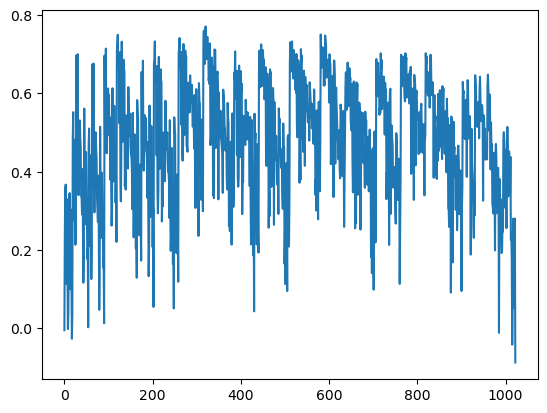

In [50]:
plt.plot([x[1][0] for x in results])

In [56]:
for x in results[:20]:
    print(x[0], x[1][0])

[0] -0.004905004676937528
[1] 0.2437934831480141
[2] 0.3562514799340359
[3] 0.36704525546996897
[4] 0.11321380626274564
[5] 0.27068309744158753
[6] 0.3296584375833236
[7] 0.16632408614009897
[8] -0.0019931266610798207
[9] 0.04052063096867026
[0, 1] 0.20387687604864851
[0, 2] 0.33993552355367784
[0, 3] 0.34527744665743043
[0, 4] 0.10026789351725067
[0, 5] 0.27420208952618375
[0, 6] 0.30290251829181475
[0, 7] 0.15305055365235648
[0, 8] -0.026655204588219322
[0, 9] 0.036742066011761554
[1, 2] 0.48577899233855215
